<a href="https://colab.research.google.com/github/danadler-dev/pygad_grammatical_evo/blob/main/PyGad_Gram_Evo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
!pip3 install pygad
!pip3 install nltk
from nltk import CFG
import nltk.grammar as GRM
from collections import defaultdict
import pygad
import numpy
import matplotlib.pyplot as plt

In [78]:
"""
Use nltk's BNF parser into dict such that:
dict[non terminal symbol] = [list of productions]
"""
def parse_BNF(s):
  grammar = CFG.fromstring(s)
  g_dict = defaultdict(list)
  for p in grammar.productions():
    g_dict[p.lhs().symbol()].append(p.rhs())
  return g_dict

Example from [Genetic Programming - Koza](https://mitpress.mit.edu/books/genetic-programming) ch. 7, and from [Grammatical Evolution - O'neil & Ryan](https://link.springer.com/chapter/10.1007/978-1-4615-0447-4_4):


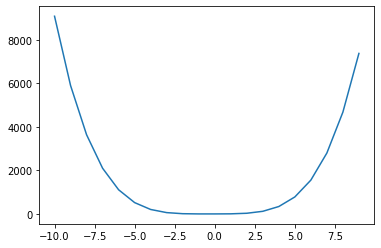

In [79]:
"""
    y = pow(x,4) + pow(x,3) + pow(x,2) + x
    Evaluated on [-10,10]
"""
tgt_expr = 'pow(x,4) + pow(x,3) + pow(x,2) + x'
rng = range(-10, 10)
tgt = numpy.array([eval(tgt_expr) for x in rng])
plt.plot(rng, tgt)


[Grammatical Evolution](https://link.springer.com/chapter/10.1007/978-1-4615-0447-4_4) is a form of Genetic Programming that takes a BNF grammar as an input and generates expressions from that grammar. The genes are a vector of integers. The generator takes each integer in the gene, and uses it to index into the number of productions available (start is the top level production). It uses modulo to wrap around in case or too few/many.


In [80]:
"""
Generate a legal expression from the grammar (represented by g_dict)
based on the number of genes passed in.
"""
def gen_from_vec(g_dict, start, vec, n=0, max_depth=100):
  if n > max_depth:
    #print('max depth exceeded:', start)
    return '0.0'
  s = g_dict[start]
  c = vec[n % len(vec)] # which index
  v = s[c % len(s)] # choice is based on index value mod num choices
  #print('gen ', start, n, c, v)
  w = list(v)
  for i in range(len(w)):
    n = n+1
    if GRM.is_nonterminal(w[i]):
      w[i] = gen_from_vec(g_dict, w[i].symbol(), vec, n=n)
  return ''.join(w)

In [81]:
bnf = """op -> "+"
  expr -> expr op term | term
  term ->  "pow(" var "," num ")" | var
  num -> "0" | "1" | "2" | "3" | "4" | "5" | "6" | "7" | "8" | "9"
  var -> "x" """

g_dict = parse_BNF(bnf)

The fitness function takes a vector of integers, generates an expression from it, and calculates the fitness as one over the MSE compared to the target evaluated on the same range.

In [82]:
def fitness_func(solution, solution_idx):
  r = gen_from_vec(g_dict, "expr", solution)
  try:
    res = numpy.array([eval(r) for x in rng])
  except SyntaxError:
    res = [0 for x in rng]
  fitness = 1.0 / numpy.mean(numpy.square(res - tgt) + 0.000001)
  return fitness

In [83]:
num_generations = 100 # Number of generations.
num_parents_mating = 20 # Number of solutions to be selected as parents in the mating pool.
sol_per_pop = 500 # Number of solutions in the population.
num_genes = 10 # length of vec passed into solution generator - to allow deep expressions
last_fitness = 0

Generation = 25
Fitness    = 0.24999993750001567
Change     = 0.18749994140626544
Generation = 50
Fitness    = 0.24999993750001567
Change     = 0.0
Generation = 75
Fitness    = 0.24999993750001567
Change     = 0.0
Generation = 100
Fitness    = 0.24999993750001567
Change     = 0.0


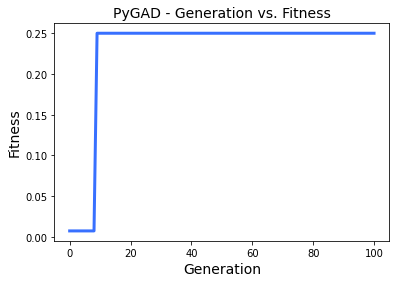

Parameters of the best solution : [0 4 6 6 2 3 4 2 3 0]
Fitness value of the best solution = 0.24999993750001567
Index of the best solution : 0
Predicted output based on the best solution : pow(x,0)+pow(x,4)+pow(x,0)+x+pow(x,3)+pow(x,2)


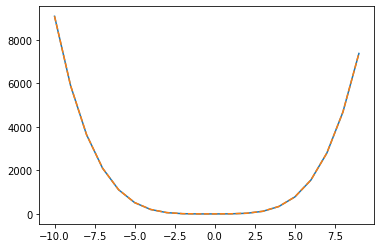

In [85]:

def on_generation(ga_instance):
    global last_fitness
    if (ga_instance.generations_completed % 25) == 0:
      print("Generation = {generation}".format(generation=ga_instance.generations_completed))
      print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
      print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
      last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       gene_type=int,
                       gene_space=range(0,20),
                       fitness_func=fitness_func,
                       on_generation=on_generation)

# Running the GA to optimize the parameters of the function.
ga_instance.run()

ga_instance.plot_fitness()

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

prediction = gen_from_vec(g_dict, "expr", solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))
fig = plt.figure()
plt.plot(rng, tgt, '-')
plt.plot(rng, numpy.array([eval(prediction) for x in rng]), '--')
plt.show()